## 1. Chain complex as quiver

Since $ \partial_k \circ \partial_{k+1} = 0$ and $\text{im } \partial_{k+1} \subset \ker\partial_k$, we can define the indecomposables with maximum 2 nontrivial vertex (i.e. $\dotsc 0 \xleftarrow{\partial} x \xleftarrow{\partial} y \xleftarrow{\partial} 0 \dotsc$ or $\dotsc 0 \xleftarrow{\partial} x \xleftarrow{\partial} 0 \dotsc$). 

More specifically, denote the vectors $\left\{v^{(k)}_i\right\}$ as the basis vectors spanning $\ker \partial_k / \text{im } \partial_{k+1}$ while $\left\{w^{(k)}_i\right\}$ as the spanning $\text{im } \partial_{k+1}$. 

We can define the indecomposable representations via $\mathbf{I}\left(v^{(k)}_i\right)$ as followed:

$$ \dotsc 0 \leftarrow v^{(k)}_i \leftarrow 0  \leftarrow 0  \dotsc$$ 

And $\mathbf{I}\left(w^{(k+1)}_i\right)$ as 

$$ \dotsc 0 \leftarrow w^{(k)}_i \leftarrow \partial^{-1} \left( w^{(k+1)}_i \right)  \leftarrow 0  \dotsc$$ 

And the homology in dimension $k$, per definition, would be $H_k(C) = \bigoplus \mathbf{I}\left(v^{(k)}_i\right) $

## Initialization for following problems

In [1]:
# Importing essentials

# General packages
import time
from copy import deepcopy
import os, glob
from itertools import combinations
import multiprocessing as mp

# General computation tool 
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import pairwise_distances as pw_dist

# TDA packages
import dionysus
import gudhi as gd

from IPython.display import display, HTML

# Specify how to print outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
# Plotting packages and customized styles
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, RegularPolygon
import seaborn as sns

def resetmplstyle(): 
    # for some reason, Gudhi resets my own style so this is needed to counter that
    # just for resetting 
    rcParams.update(mpl.rcParamsDefault)
    plt.style.use('default')

    # use one of the available styles 
    plt.style.use('seaborn-notebook')

    # further customization
    rcParams['font.family'] = 'FreeSans'
    rcParams['font.size'] = 20

    rcParams['axes.titlesize'] = 17
    rcParams['axes.labelsize'] = 17
    rcParams['legend.fontsize'] = 16
    rcParams['xtick.labelsize'] = 16
    rcParams['ytick.labelsize'] = 16
    rcParams['axes.linewidth'] = 1

    rcParams['mathtext.fontset'] = 'cm' 
    rcParams['mathtext.rm'] = 'serif'

    # Disable Tex rendering
    gd.persistence_graphical_tools._gudhi_matplotlib_use_tex=False
    
resetmplstyle()
%matplotlib inline

In [3]:
# Sometimes needed 
# import matplotlib.font_manager
# matplotlib.font_manager._rebuild()

In [4]:
# General utils functions
def flatten_list(L):
    """ Simple flatten a double-nested list, also flatten 2D matrix if needed, return list"""
    Lf = []
    [Lf.extend(li) for li in L]
    return Lf

def sample_unitsquare(n,noise=0):
    """
    Sample unit square with `n` samples uniformly, 
        with another added uniform displacemento the coordinates of size `noise` 
    """
    X1 = np.random.uniform(low=-0.5,high=0.5,size=(n,1))
    X2 = np.random.choice([-0.5,0.5], size=(n,1))
    mid_n = int(n/2)
    X = np.hstack((X1,X2))
    X[mid_n:,[0,1]] = X[mid_n:,[1,0]]
    X += noise/2 * np.random.uniform(low=-1,high=1,size=X.shape)
    return X

def sample_unitcircle(n,noise=0):
    """
    Sample unit circle with `n` samples uniformly, 
        with another added uniform displacement noise to the coordinates of size `noise` 
    """
    thetav = np.random.uniform(low=0,high=2*np.pi,size=(n,1))
    X = np.hstack((np.cos(thetav),np.sin(thetav)))
    X += noise/2 * np.random.uniform(low=-1,high=1,size=X.shape)
    return X
    

## 2. Filtrations

### 2.1 Lower-star filtrations

Obtain an example simplicial complex from a unit circle with Rips complex 

Example function on vertices as the y-coordinates 

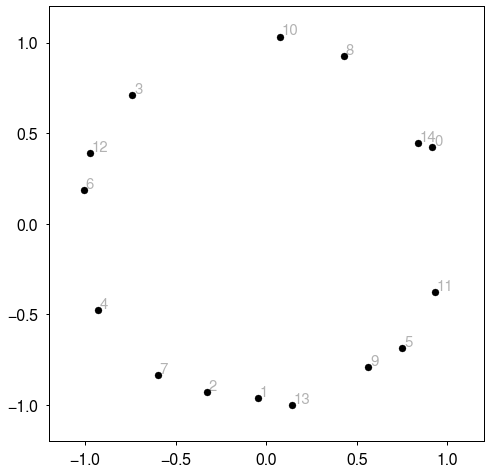

In [5]:
np.random.seed(1283) # for reproducibility 

X = sample_unitcircle(n=15,noise=0.1)

plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1],c='k')
[plt.annotate(i,(x+0.01,y+0.01),fontsize=15,alpha=0.3) 
 for i,(x,y) in enumerate(X)] # for demo purposes
plt.axis([-1.2,1.2,-1.2,1.2])
plt.gca().set_aspect('equal')

In [6]:
# Get the Rips simplicial complex 
rips_tree = gd.RipsComplex(X, max_edge_length = 0.7).create_simplex_tree(max_dimension = 2)
rips_list = list(rips_tree.get_filtration())
spx_cpx = [x[0] for x in rips_list] 

# Define an example function on the vertices 
def vert_func(i):
    return X[i,1]

In [7]:
def lowerstar_filtration(spx_cpx, vert_func):
    """
    Return lower star filtration from simplicial complex list 
    `spx_cpx` using the function on vertices `vert_func`
    """
    vertex_list = set(flatten_list(spx_cpx))
    f_vert = np.array([vert_func(i) for i in vertex_list])
    max_f = np.array([max(f_vert[spx]) for spx in spx_cpx])
    ind_sort = np.argsort(max_f)
    max_f = max_f[ind_sort]
    spx_cpx = np.array(spx_cpx,dtype=object)[ind_sort]
    return list(zip(spx_cpx, max_f))

In [8]:
lowerstar_filtration(spx_cpx, vert_func)

[([13], -0.9983581622055497),
 ([1, 13], -0.9617538612829322),
 ([1], -0.9617538612829322),
 ([1, 2], -0.927397939229246),
 ([2, 13], -0.927397939229246),
 ([1, 2, 13], -0.927397939229246),
 ([2], -0.927397939229246),
 ([1, 7], -0.8361488096758014),
 ([7], -0.8361488096758014),
 ([1, 2, 7], -0.8361488096758014),
 ([2, 7], -0.8361488096758014),
 ([9], -0.7908797215086621),
 ([1, 9], -0.7908797215086621),
 ([9, 13], -0.7908797215086621),
 ([1, 9, 13], -0.7908797215086621),
 ([5, 9], -0.6836612802115462),
 ([5, 13], -0.6836612802115462),
 ([5, 9, 13], -0.6836612802115462),
 ([5], -0.6836612802115462),
 ([4], -0.4738961359850098),
 ([4, 7], -0.4738961359850098),
 ([9, 11], -0.37554976817525665),
 ([5, 11], -0.37554976817525665),
 ([11], -0.37554976817525665),
 ([5, 9, 11], -0.37554976817525665),
 ([4, 6], 0.1875664612102429),
 ([6], 0.1875664612102429),
 ([12], 0.3890692603815639),
 ([6, 12], 0.3890692603815639),
 ([0], 0.42298876060951274),
 ([14], 0.44531489005900526),
 ([0, 14], 0.44531

### 2.2 Rips filtration

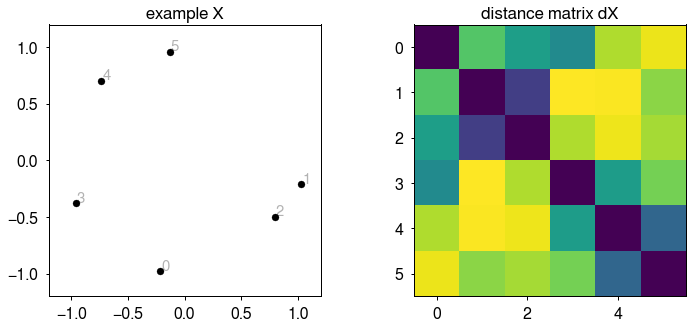

In [9]:
np.random.seed(3858) # for reproducibility 
X = sample_unitcircle(n=6,noise=0.1) 

dX = pw_dist(X, metric='euclidean') # pairwise distance matrix 

# Plot the example data
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c='k')
[plt.annotate(i,(x+0.01,y+0.01),fontsize=15,alpha=0.3) 
 for i,(x,y) in enumerate(X)] # for demo purposes
plt.axis([-1.2,1.2,-1.2,1.2])
plt.gca().set_aspect('equal')
plt.title('example X')

plt.subplot(122)
plt.imshow(dX)
plt.title('distance matrix dX')
plt.show()

In [10]:
def naive_rips_filtration(dX, k):
    """
    Return Rips filtration from pairwise distance matrix `dX` and maximum simplex dimension `k`
    dX: pairwise distance matrix, N x N
    k: maximum simplex dimension
    """
    
    N = dX.shape[0]
    vertex_list = np.arange(N)
    dist_list = np.unique(dX)

    # Add 0-simplices 
    spx_cpx = [] 
    filt_val = []
    [spx_cpx.append({v}) or filt_val.append(0.0)  for v in vertex_list]

    for d in dist_list:
        rv, cv = np.where(dX == d)
        rv, cv = rv[rv < cv], cv[rv < cv] # reduce duplicates 
        
        # Add 1-simplices 
        [spx_cpx.append({ri, ci}) or filt_val.append(d) for ri, ci in zip(rv,cv)]

        # Add higher-order simplices only if all faces exist
        for ki in range(2,k+1):
            for s in combinations(vertex_list,ki+1):
                if set(s) in spx_cpx: 
                    continue
                else:
                    s = np.array(s)
                    all_faces_exist = np.all(
                        [set(s[list(fi)]) in spx_cpx 
                         for fi in combinations(range(ki+1),ki)]                
                    )
                    if all_faces_exist: 
                        spx_cpx.append(set(s))
                        filt_val.append(d)

    naive_rips_filt = list(zip(spx_cpx,filt_val))
    return naive_rips_filt

In [11]:
k = 2

# Naive Rips filtration
naive_rips_filt = naive_rips_filtration(dX, k)

# Gudhi Rips filtration
gd_rips_tree = gd.RipsComplex(X).create_simplex_tree(max_dimension = k)
gd_rips_filt = list(gd_rips_tree.get_filtration())

In [12]:
# Compare the implementation
def spx2str(x):
    return "(%s, %.3g)" %("".join(str(set(x[0]))), x[1])
str_naiverips = list([spx2str(x) for x in naive_rips_filt])
str_gdrips = list([spx2str(x) for x in gd_rips_filt]) 

df = pd.DataFrame({'naive': list(str_naiverips), 'gudhi': list(str_gdrips)})

print('Table of Rips filtration')
display(df)

print('Are naive and Gudhi filtration the same? %s ' %(['NO','YES'][str_naiverips == str_gdrips]))


Table of Rips filtration


,naive,gudhi
0,"({0}, 0)","({0}, 0)"
1,"({1}, 0)","({1}, 0)"
2,"({2}, 0)","({2}, 0)"
3,"({3}, 0)","({3}, 0)"
4,"({4}, 0)","({4}, 0)"
5,"({5}, 0)","({5}, 0)"
6,"({1, 2}, 0.367)","({1, 2}, 0.367)"
7,"({4, 5}, 0.656)","({4, 5}, 0.656)"
8,"({0, 3}, 0.956)","({0, 3}, 0.956)"
9,"({3, 4}, 1.11)","({3, 4}, 1.11)"


Are naive and Gudhi filtration the same? YES 


## 3. Persistent homology

In [13]:
np.random.seed(4283) # for reproducibility 

X = sample_unitcircle(n=100,noise=0.15)
gd_rips_tree = gd.RipsComplex(X).create_simplex_tree(max_dimension = k)
barcode = gd_rips_tree.persistence()

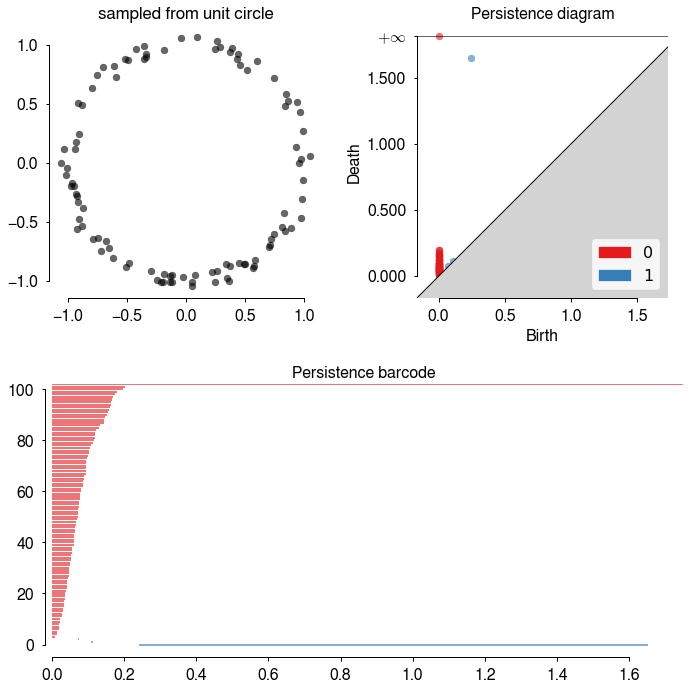

In [14]:
fig = plt.figure(figsize=(10,10))

# Plot data samples
plt.subplot(221)
plt.scatter(X[:,0],X[:,1],c='k',alpha=0.6)
plt.gca().set_aspect('equal')
sns.despine(trim=True)
plt.title('sampled from unit circle')

# Plot persistence diagram
gd.plot_persistence_diagram(barcode, axes=plt.subplot(222), legend=True)
plt.gca().set_aspect('equal')
resetmplstyle() 

# Plot persistence barcode
gd.plot_persistence_barcode(barcode, axes=plt.subplot(212))
resetmplstyle()
plt.axis([-0.02,1.75,-5,102])
sns.despine(trim=True)

plt.tight_layout()
plt.show()

As expected, there is one quite persistent bar in $H_0$ representing one connected component, while there is also one persistent bar in $H_1$ representing the cycle creating 2D hole ("persistence" here can be refered to as bars $\sim$ lasting at least $d-b \ge 1$). There are a few bars in both $H_0$ and $H_1$ lasting for only a short while ($d-b \lt 0.25$) that don't represent the topology of the data, as expected as well. 

## 4. Bottleneck distance of unit circles and unit squares

In [15]:
np.random.seed(9387) # for reproducibility 

n = 100
noise = 0.05

Xs = {
    'square 1': sample_unitsquare(n, noise),
    'square 2': sample_unitsquare(n, noise),
    'circle 1': sample_unitcircle(n, noise), 
    'circle 2': sample_unitcircle(n, noise),
     }

N = len(Xs)
labels = list(Xs.keys())


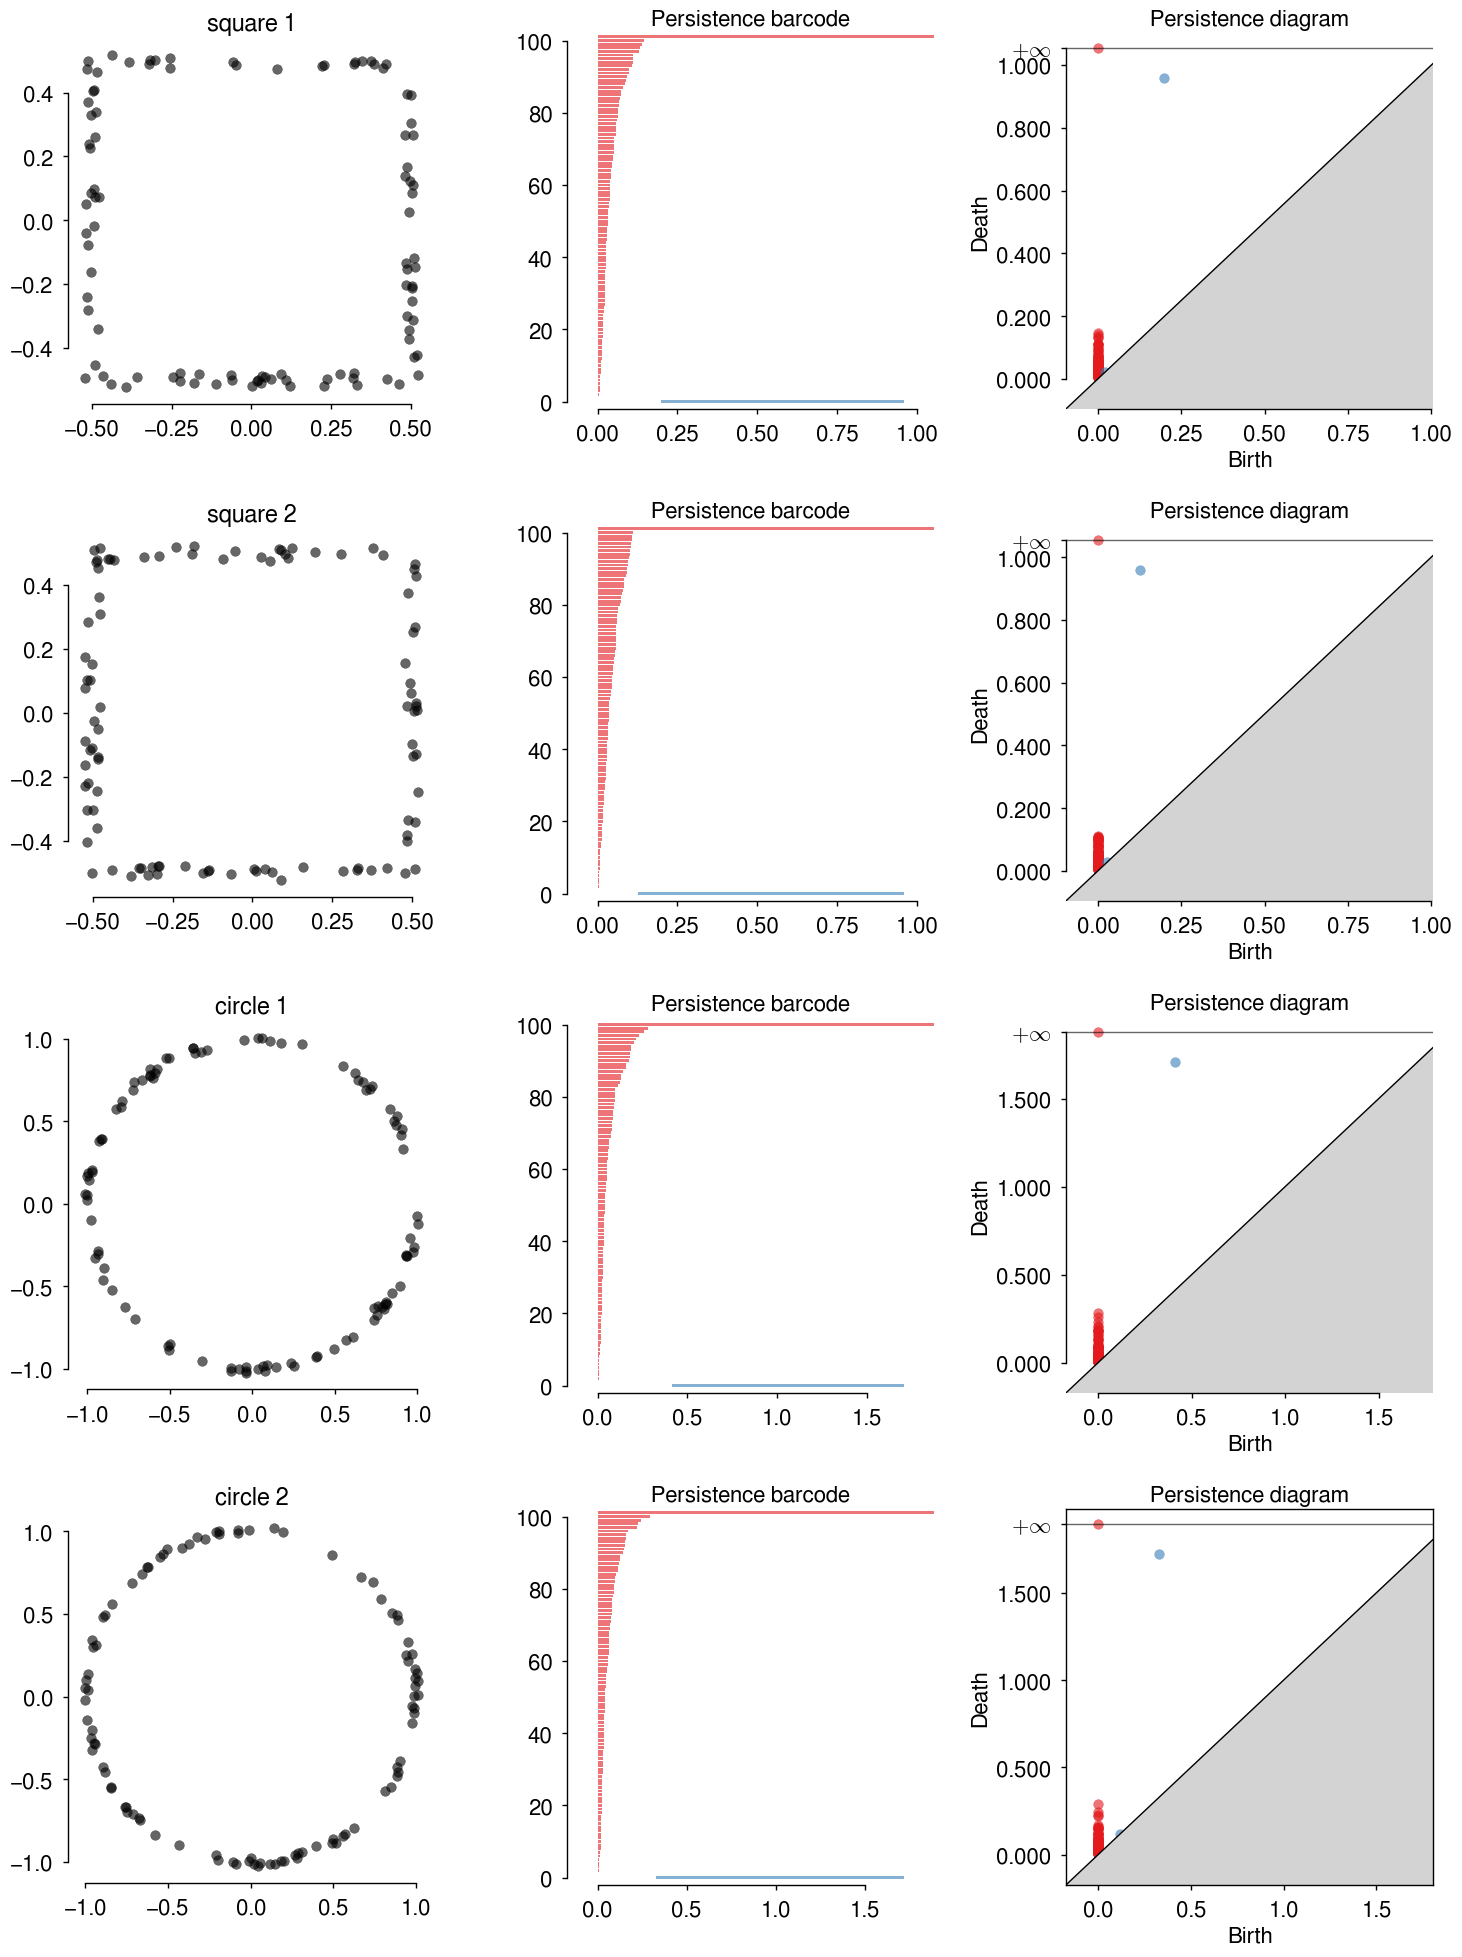

In [16]:
I1s = {} 

fig = plt.figure(figsize=(15,20))
for i,(lbl,X) in enumerate(Xs.items()):
    # Plot sample data
    plt.subplot(N,3,i*3+1)
    plt.scatter(X[:,0],X[:,1],c='k',alpha=0.6)
    plt.title(lbl)
    plt.gca().set_aspect('equal')
    sns.despine(trim=True)
    
    # Obtain persistence homology analysis 
    gd_rips_tree = gd.RipsComplex(X).create_simplex_tree(max_dimension = 2)
    barcode = gd_rips_tree.persistence()
    I1s[lbl] = gd_rips_tree.persistence_intervals_in_dimension(1) # get persistence 
    
    # Plot persistence barcode
    gd.plot_persistence_barcode(barcode, axes=plt.subplot(N,3,i*3+2))
    resetmplstyle()
    sns.despine(trim=True)
    plt.ylim([-2,102])
    
    # Plot persistence diagram
    gd.plot_persistence_diagram(barcode, axes=plt.subplot(N,3,i*3+3))
    resetmplstyle()
    
plt.tight_layout()
plt.show()

In [17]:
display(I1s)

{'square 1': array([[0.01971654, 0.02125993],
        [0.19713359, 0.95717376]]),
 'square 2': array([[0.0266589 , 0.02763323],
        [0.12503462, 0.95751612]]),
 'circle 1': array([[0.41346585, 1.70613839]]),
 'circle 2': array([[0.11763315, 0.11845852],
        [0.32836128, 1.71922915]])}

In [18]:
dist_mat = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        I1_i, I1_j = I1s[labels[i]], I1s[labels[j]]
        dist_mat[i,j] = gd.bottleneck_distance(I1_i, I1_j)
display(pd.DataFrame(dist_mat))

,0,1,2,3
0,1.691146e-308,7.209897e-02,6.463363e-01,6.954339e-01
1,7.209897e-02,1.852333e-308,6.463363e-01,6.954339e-01
2,6.463363e-01,6.463363e-01,2.179822e-308,8.510457e-02
3,6.954339e-01,6.954339e-01,8.510457e-02,1.777487e-308


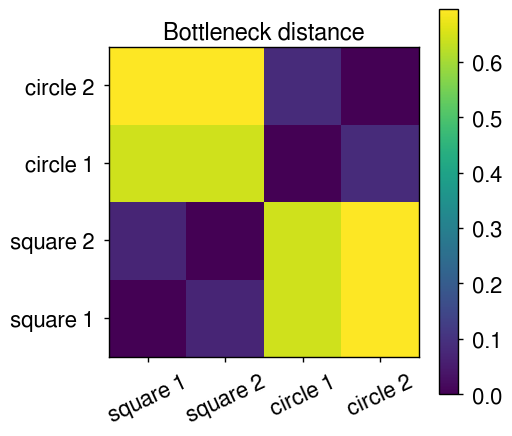

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(dist_mat,origin='lower')
plt.xticks(ticks=range(N),labels=labels,rotation=25)
plt.yticks(ticks=range(N),labels=labels)
plt.colorbar()
plt.title('Bottleneck distance')
plt.show()

The distances between the data generated from the same categories are smaller than those from different categories. This is probably because of the scale that these data are generated. More specifically, the unit squares lie within $[-0.5,0.5]$ range of both coordinates, while the unit circles lie within $[-1,1]$. Scaling so the areas occupied by these objects being roughly the similar would scale these differences across groups down, for example, by scaling the sides of the unit squares by $\sqrt{\pi}$. Indeed in did. 

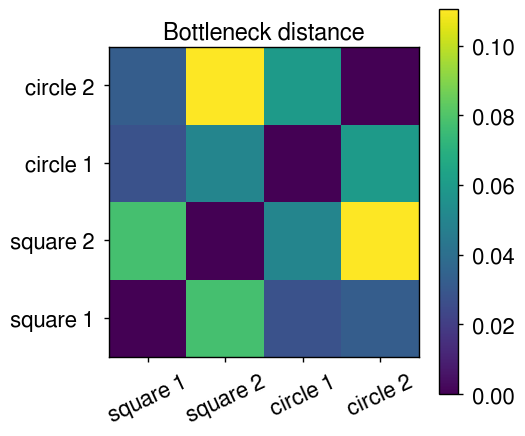

In [20]:
np.random.seed(397)  

Xs = {
    'square 1': np.sqrt(np.pi)*sample_unitsquare(n, noise),
    'square 2': np.sqrt(np.pi)*sample_unitsquare(n, noise),
    'circle 1': sample_unitcircle(n, noise), 
    'circle 2': sample_unitcircle(n, noise),
     }

# Obtain persistence homology analysis 
I1s = {}
for i,(lbl,X) in enumerate(Xs.items()):    
    gd_rips_tree = gd.RipsComplex(X).create_simplex_tree(max_dimension = 2)
    barcode = gd_rips_tree.persistence()
    I1s[lbl] = gd_rips_tree.persistence_intervals_in_dimension(1) # get persistence 

# Bottleneck distance matrix 
dist_mat = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        I1_i, I1_j = I1s[labels[i]], I1s[labels[j]]
        dist_mat[i,j] = gd.bottleneck_distance(I1_i, I1_j)

# Plot distance matrix
plt.figure(figsize=(5,5))
plt.imshow(dist_mat,origin='lower')
plt.xticks(ticks=range(N),labels=labels,rotation=25)
plt.yticks(ticks=range(N),labels=labels)
plt.colorbar()
plt.title('Bottleneck distance')
plt.show()

## 5. Data analysis - Texture

In [21]:
data_files = glob.glob('data/rotate/*tiff')

In [22]:
def pair2vert(i,j):
    return 512*i + j
def vert2pair(k):
    return divmod(k,512)
def compute_feature(I):
    f = (I[:,1] - I[:,0]) * (I[:,1] + I[:,0]) 
    divby = len(f)*256*256
    f = np.sum(f[~np.isinf(f)])/divby
    return f

def process_tiff(file_name):
    label, _ = os.path.splitext(os.path.basename(file_name))
    label, _ = os.path.splitext(label)
    
    X = np.array(Image.open(file_name),dtype=float)
    
    S = X.shape[0]
    st = gd.SimplexTree()
    for v in range(S*S):
        i,j = vert2pair(v)
        st.insert([v], X[i,j])

    for i in range(S-1):
        for j in range(S-1):
            sq_p = [(i,j), (i,j+1), (i+1,j), (i+1,j+1)]
            sq_v = [pair2vert(ix,jx) for ix,jx in sq_p]
            sq_x = [X[ix,jx] for ix,jx in sq_p]
            spx = [(0,1),(0,2),(0,3)]
            [st.insert([sq_v[i1],sq_v[i2]], max(sq_x[i1], sq_x[i2])) for i1,i2 in spx]

    for i in range(S-1):
        for j in range(S-1):
            sq_p = [(i,j), (i,j+1), (i+1,j), (i+1,j+1)]
            sq_v = [pair2vert(ix,jx) for ix,jx in sq_p]
            sq_x = [X[ix,jx] for ix,jx in sq_p]
            spx = [(0,1,3),(0,2,3)]
            [st.insert([sq_v[i1],sq_v[i2],sq_v[i3]], 
                       max(sq_x[i1], sq_x[i2], sq_x[i3])) 
             for i1,i2,i3 in spx]

    barcode = st.persistence()

    I0 = st.persistence_intervals_in_dimension(0)
    I1 = st.persistence_intervals_in_dimension(1)

    feats = [compute_feature(I0), compute_feature(I1)]
    
    return (feats, label)


In [23]:
# # Dont run this again if already has data saved
# #. Took around 4-5min without parallelization, aroud 1-1.5min with it. 
# pool = mp.Pool(int(mp.cpu_count()/2))

# # Computing features 
# t0 = time.time()
# results = pool.map(process_tiff, data_files)
# pool.close()
# t1 = time.time()
# elapsed = (t1-t0)/60
# print('Elapsed %.1f min' %(elapsed))

# # Converting to desired format 
# X = []
# labels = []
# for x, lbl in results:
#     X.append(x)
#     labels.append(lbl)
# X = np.array(X)
# labels = np.array(labels)

# # Saving CSV
# df = pd.DataFrame(np.hstack((X,labels[:,None])),columns=['X0','X1','labels'])
# df.to_csv('data/ph-feats.csv', index=False)

In [24]:
df = pd.read_csv('data/ph-feats.csv')
X = np.vstack((df.X0,df.X1)).T
labels = df.labels.to_numpy()
display(df)

,X0,X1,labels
0,0.039919,0.041578,sand
1,0.032778,0.041349,wool
2,0.035569,0.024356,brick
3,0.017684,0.074179,leather
4,0.021107,0.019380,water
...,...,...,...
86,0.028756,0.034127,pigskin
87,0.020736,0.019470,water
88,0.041317,0.064840,grass
89,0.017413,0.068064,leather


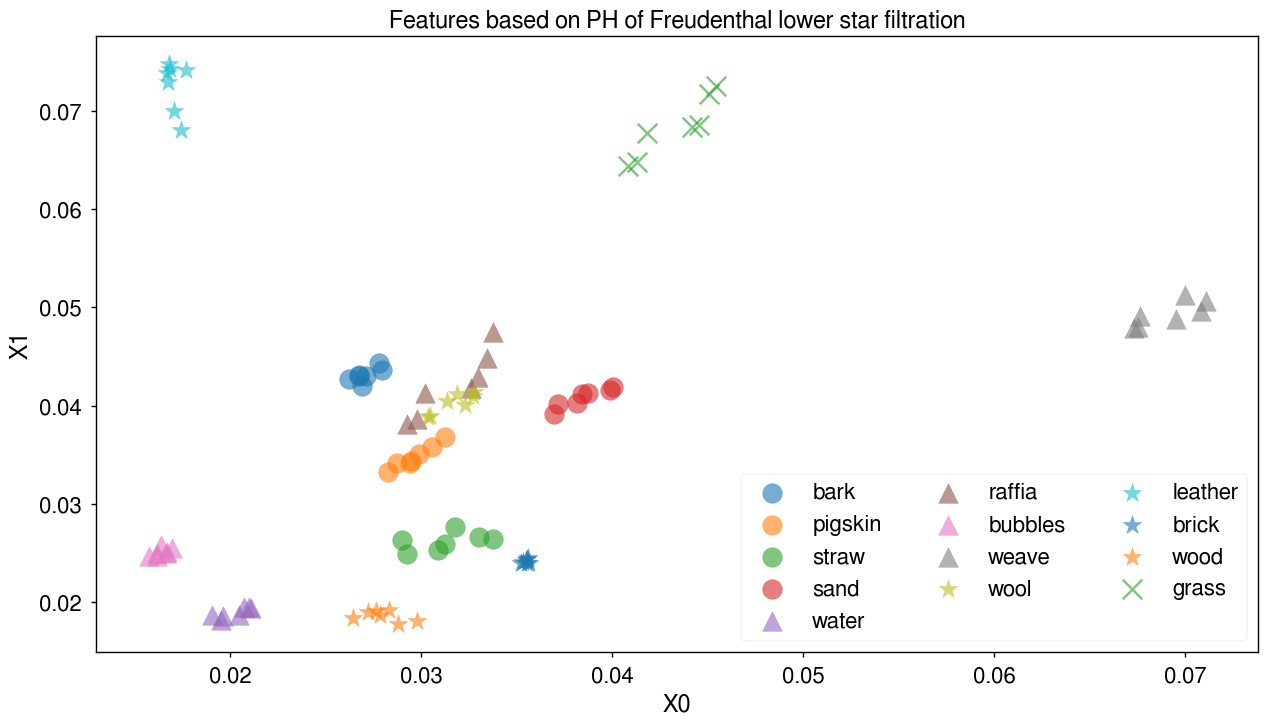

In [25]:
markers = ["o"]*4 + ["^"]*4 + ["*"]*4 + ["x"]

plt.figure(figsize=(15,8))
[plt.scatter(X[labels == Y,0], X[labels == Y,1], 
             label=Y, s=200, alpha=0.6,marker=m)
 for m,Y in zip(markers,set(labels))]
plt.legend(ncol=3,loc='lower right')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Features based on PH of Freudenthal lower star filtration')

plt.show()

The different textures are quite well separate based on the features built only from the first 2 dimensions of persistent homology, except for very few textures having overlap (like wool and raffia, which is understandable since they look quite close). Overall, using clustering or SVM would be sufficient to obtain good results of classification. 

An intuitive method to compare to would be utilizing the frequency domain features, as textures do have certain smooth/coarse properties that can be characterized in the frequency domain. A simple way to build up features is to use 2D FFT, then apply an average 2D filter then subsample the spectrum in log scale in the frequency axis. Then flatten the spectrum, and do a PCA on the whole data set. In the following, each spectrum is subsampled to be $9 \times 9$ (in other words $81$ features per data), and plotting only the first 2 principal components 

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import convolve2d

pca = PCA(n_components=2,whiten=True)

In [27]:
def process_tiff_fft(file_name,box_size=8,kpow_subsampled=9):
    label, _ = os.path.splitext(os.path.basename(file_name))
    label, _ = os.path.splitext(label)
    
    X = np.array(Image.open(file_name),dtype=float)
    F = np.abs(np.fft.fft2(X))
    
    box = np.ones((box_size,box_size))
    f_X = convolve2d(F,box/np.sum(box))
    subsampled = 2**(np.arange(kpow_subsampled))
    f_X = f_X[subsampled,:][:,subsampled].flatten()
    
    return (f_X, label)

In [28]:
# # This took around 0.1 min without any parallelization
# # Generate features
# t0 = time.time()
# results = [process_tiff_fft(file) for file in data_files]
# t1 = time.time()
# elapsed = (t1-t0)/60

# # Get into desired format + PCA
# X = []
# labels = []
# for x, lbl in results:
#     X.append(x)
#     labels.append(lbl)
# X = np.array(X)
# X = projections.fit_transform(X)
# labels = np.array(labels)

# # Save data to CSV
# df = pd.DataFrame(np.hstack((X,labels[:,None])),columns=['X0','X1','labels'])
# df.to_csv('data/freq-feats.csv', index=False)

# print('Elapsed %.1f min' %(elapsed))

In [29]:

feat_dict = dict(
    ph = dict(
        label = 'X',
        title = 'Features based on persistent homology',
        file = 'data/ph-feats.csv'
    ), 
    freq = dict(
        label = 'PC',
        title = 'Features based on frequency properities',
        file = 'data/freq-feats.csv'
    )
)


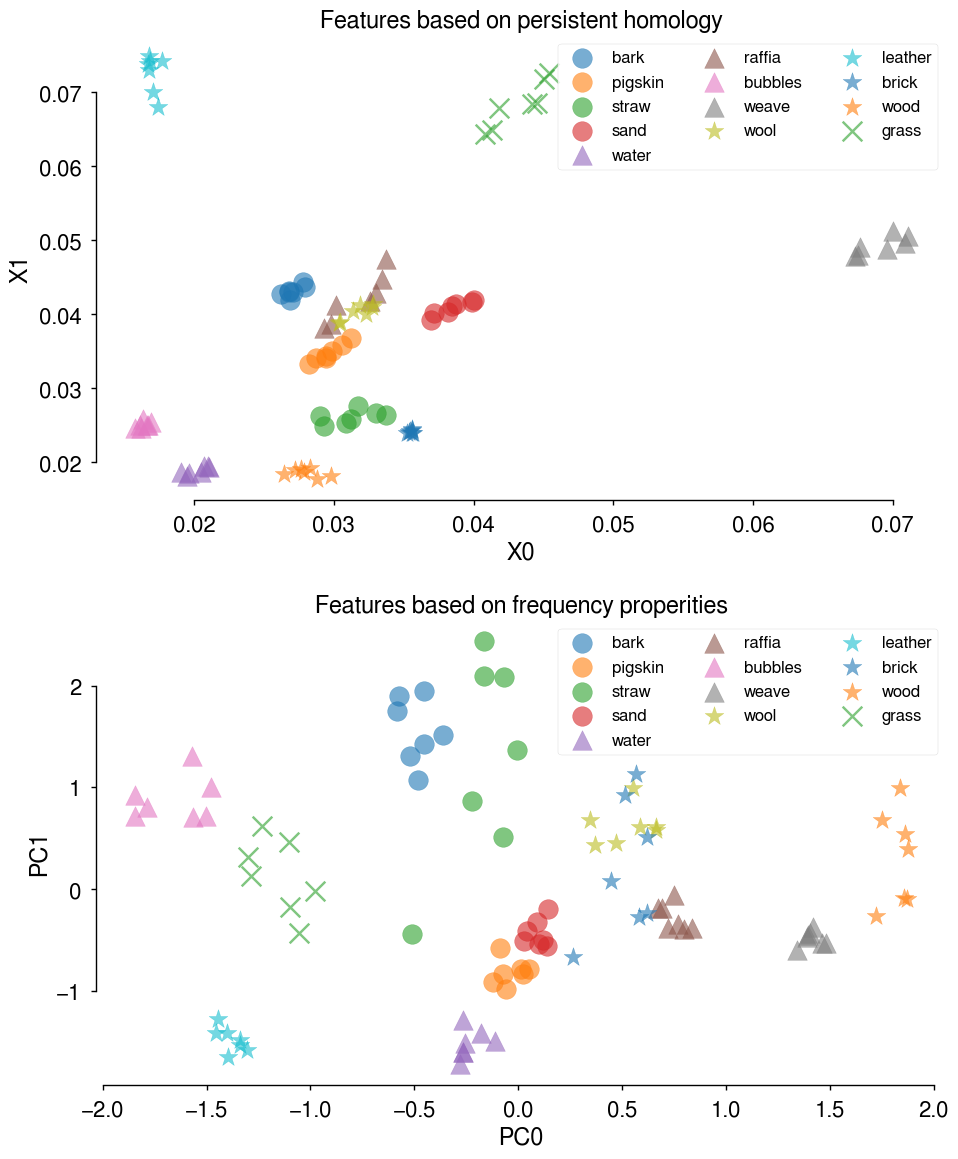

In [30]:
markers = ["o"]*4 + ["^"]*4 + ["*"]*4 + ["x"]

plt.figure(figsize=(10,12))

for i,d in enumerate(feat_dict.values()):
    plt.subplot(2,1,i+1)
    df = pd.read_csv(d['file'])    
    X = np.vstack((df.X0,df.X1)).T
    labels = df.labels.to_numpy()
    [plt.scatter(X[labels == Y,0], X[labels == Y,1], 
             label=Y, s=200, alpha=0.6,marker=m)
     for m,Y in zip(markers,set(labels))]
    plt.legend(ncol=3,loc='best',fontsize=12)
    plt.xlabel(d['label'] + '0')
    plt.ylabel(d['label'] + '1')
    plt.title(d['title'])
    sns.despine(trim=True)

plt.tight_layout()
plt.show()

Using the frequency properties this way seems to get somewhat a good separation, but not as good as the features built from persistent homology, as there are more class overlap in the former. However, one benefit of the former is that the time to generate the features is much faster (0.1 minutes for frequency vs > 4 minutes for PH). Additionally, there are better ways of building features from the frequency domains than what's being done here, so another frequency-based method with fast feature-building time might be comparable to PH's results. 

Of course, though not done here, using CNN would possibly achieve much better results than both of these, but training time and inference time might be worse than both of these methods, depending on the available computing resources (e.g: CPU vs GPU). Additionally, I'd expect CNN to generalize to certain invariant properties like scaling and occlusion as well, while the above methods might be sensitive, especially the frequency-based method, though PH might be a bit less affected. It'd be interesting to test these. 